Laboratorio #7
- Marco Ramírez
- Estuardo Hernández

Preparación de la data para los ataques

In [57]:
# Importamos las librerías a utilizar
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from art.estimators.classification import KerasClassifier # No soporta TF 2
tf.compat.v1.disable_eager_execution()
import pandas as pd
import os
from PIL import Image
from keras.utils import image_dataset_from_directory
from art.attacks.extraction import CopycatCNN
from keras import models, layers
import tensorflow_datasets as tfds
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [58]:
# Utilizamos las 939 imágenes que separamos para el ataque y creamos un dataframe
dir = "./random_imgs/"
imgs_location = './selected/selected'
data = []
for family in os.scandir(dir):
    if family.is_dir:
        for malware in os.scandir(family):
            width, height = Image.open(malware.path).size
            data.append({ 
                "name": malware.name, 
                "path": malware.path,
                "family": family.name,
                "width": width,
                "height": height,
            })
    

df = pd.DataFrame(data, columns=["name", "path", "family", "width", "height"])
df

,name,path,family,width,height
0,000e30a0819ac7ed931d629ce2ef8948.png,./random_imgs/Adialer.C\000e30a0819ac7ed931d62...,Adialer.C,512,409
1,002f06eff1d222560939be72583d6ae9.png,./random_imgs/Adialer.C\002f06eff1d222560939be...,Adialer.C,512,410
2,0046a83d932a3d431eb21a99b46d6af7.png,./random_imgs/Adialer.C\0046a83d932a3d431eb21a...,Adialer.C,512,409
3,01aa7da4d2709a0ceb69771fc837730c.png,./random_imgs/Adialer.C\01aa7da4d2709a0ceb6977...,Adialer.C,512,409
4,01fac2472eab8532d8f5951ff48637d4.png,./random_imgs/Adialer.C\01fac2472eab8532d8f595...,Adialer.C,512,410
...,...,...,...,...,...
934,07df93176f9eb61f1cb7a885d8829fbb.png,./random_imgs/Yuner.A\07df93176f9eb61f1cb7a885...,Yuner.A,768,683
935,08004d4675258aa177d07235eb0375ed.png,./random_imgs/Yuner.A\08004d4675258aa177d07235...,Yuner.A,768,683
936,0823d0fa9e21cee43174ecd9931846d4.png,./random_imgs/Yuner.A\0823d0fa9e21cee43174ecd9...,Yuner.A,768,683
937,0860ed8a40ea6a2acd816426da6ed1a9.png,./random_imgs/Yuner.A\0860ed8a40ea6a2acd816426...,Yuner.A,768,683


In [59]:
# Agrupamos por familia
def get_stratified_sample(df, amount, seed=12345):
    return df.groupby('family', as_index=False, group_keys=False) \
                .apply(lambda s: s.sample(min(amount, len(s)), random_state=seed))
df2 = get_stratified_sample(df, 100)

In [ ]:
# Extraemos el path de cada imagen a una carpeta
for _, row in df2.iterrows():
    os.makedirs(os.path.join(imgs_location, row['family']), exist_ok=True)
    os.symlink(os.path.abspath(row['path']), os.path.join(imgs_location, row['family'], row['name']))

In [60]:
# Dividir en entrenamiento y prueba
test_data = image_dataset_from_directory(
    imgs_location,
    image_size=(80, 80),
    shuffle=True,
    validation_split=0.2,
    subset='validation',
    seed=191919,
)


training_data = image_dataset_from_directory(
    imgs_location,
    image_size=(80, 80),
    shuffle=True,
    validation_split=0.2,
    subset='training',
    seed=191919,
)

Found 672 files belonging to 25 classes.
Using 134 files for validation.
Found 672 files belonging to 25 classes.
Using 538 files for training.


Ataque de extracción

In [61]:
# Cargamos el modelo
vulnerable_model = tf.keras.models.load_model("malware-class.h5")

In [62]:
# Utilizamos el KerasClassifier
clasificador = KerasClassifier(
    model=vulnerable_model
)

In [64]:
# Crear la red neuronal que robará el modelo original
copycat_cnn = CopycatCNN(
    batch_size_fit=80,
    batch_size_query=80,
    nb_epochs=20,
    nb_stolen=20000,
    classifier=clasificador
    )

In [65]:
# Definimos un nuevo modelo
blank_model = models.Sequential([
  layers.Rescaling(1./255, input_shape=(80, 80, 3)),     # normalizacion
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(test_data.class_names), activation='softmax')
])

# Compilamos el modelo
blank_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [66]:
# Definimos el modelo robado
model_stolen = KerasClassifier(
    model=blank_model
)

In [67]:
# Agregamos etiquetas a cada imagen
training_labels = []
training_images = []
for image, label in tfds.as_numpy(training_data):
    training_labels.extend(label)
    training_images.extend(image)

In [68]:
# Extraemos el modelo robado entrenando el modelo referenciado
stolen_classifier = copycat_cnn.extract(
    x=np.array(training_images), 
    y=np.array(training_labels), 
    thieved_classifier=model_stolen
    )

c:\Users\xavih\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 538 samples
Epoch 1/20
538/538 [==============================] - 2s 4ms/sample - loss: 1.2707 - accuracy: 0.7751
Epoch 2/20
538/538 [==============================] - 1s 3ms/sample - loss: 0.4332 - accuracy: 0.9108
Epoch 3/20
538/538 [==============================] - 1s 3ms/sample - loss: 0.3255 - accuracy: 0.9108
Epoch 4/20
538/538 [==============================] - 1s 3ms/sample - loss: 0.2355 - accuracy: 0.9145
Epoch 5/20
538/538 [==============================] - 1s 3ms/sample - loss: 0.1858 - accuracy: 0.9368
Epoch 6/20
538/538 [==============================] - 1s 3ms/sample - loss: 0.1641 - accuracy: 0.9480
Epoch 7/20
538/538 [==============================] - 2s 3ms/sample - loss: 0.1261 - accuracy: 0.9684
Epoch 8/20
538/538 [==============================] - 2s 3ms/sample - loss: 0.1022 - accuracy: 0.9703
Epoch 9/20
538/538 [==============================] - 1s 3ms/sample - loss: 0.0782 - accuracy: 0.9777
Epoch 10/20
538/538 [==============================] - 1s 3ms

In [69]:
# Para comparar el modelo original con el robado, predecimos las labels utilizando ambos modelos con las imagenes de test
# Primero el modelo original
og_probabilities = []
og_true_labels = []

test_images, test_labels = zip(*tfds.as_numpy(test_data))
for img_batch, label_batch in zip(test_images, test_labels):
    probability_batch = clasificador.predict(img_batch)
    og_probabilities.extend(probability_batch)
    og_true_labels.extend(label_batch)

og_probabilities = np.array(og_probabilities)
og_true_labels = np.array(og_true_labels)

og_predicted_labels = np.argmax(og_probabilities, axis=-1)

In [70]:
# Ahora el modelo robado
stolen_probabilities = []
stolen_true_labels = []

for img_batch, label_batch in zip(test_images, test_labels):
    probability_batch = stolen_classifier.predict(img_batch)
    stolen_probabilities.extend(probability_batch)
    stolen_true_labels.extend(label_batch)

stolen_probabilities = np.array(stolen_probabilities)
stolen_true_labels = np.array(stolen_true_labels)

stolen_predicted_labels = np.argmax(stolen_probabilities, axis=-1)

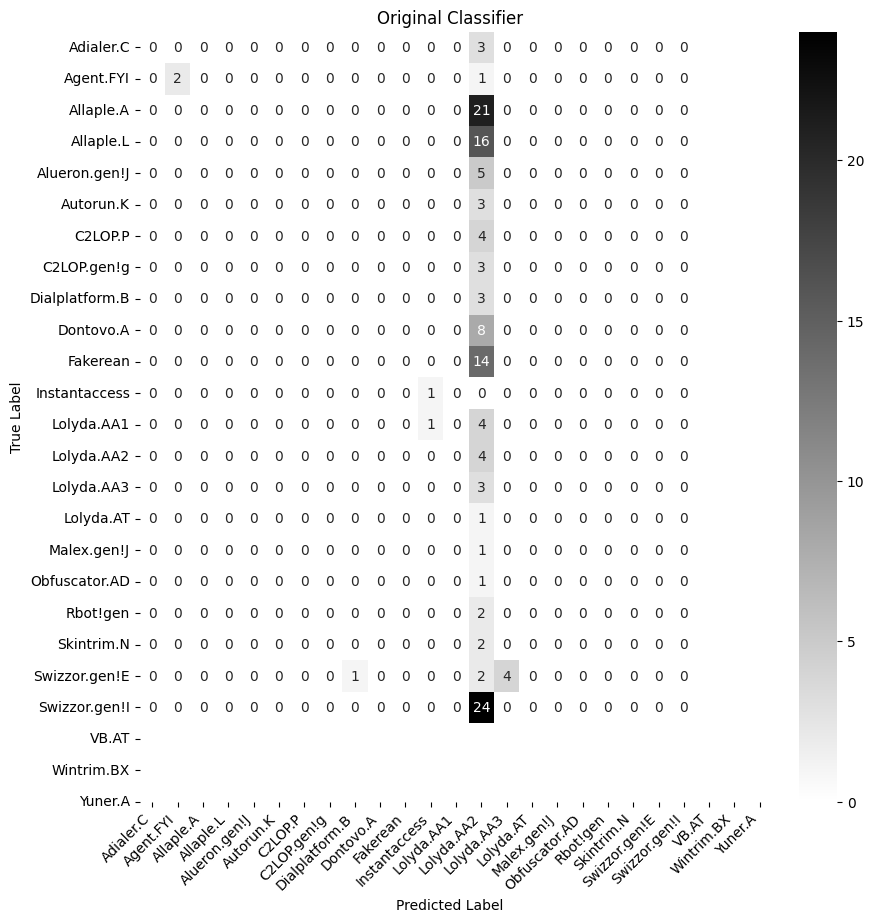

In [55]:
# Comparamos utilizando una matriz de confusion del modelo original
cm = confusion_matrix(og_true_labels, og_predicted_labels)
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='binary', cbar=True, xticklabels=test_data.class_names, yticklabels=test_data.class_names)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Original Classifier')
plt.show()

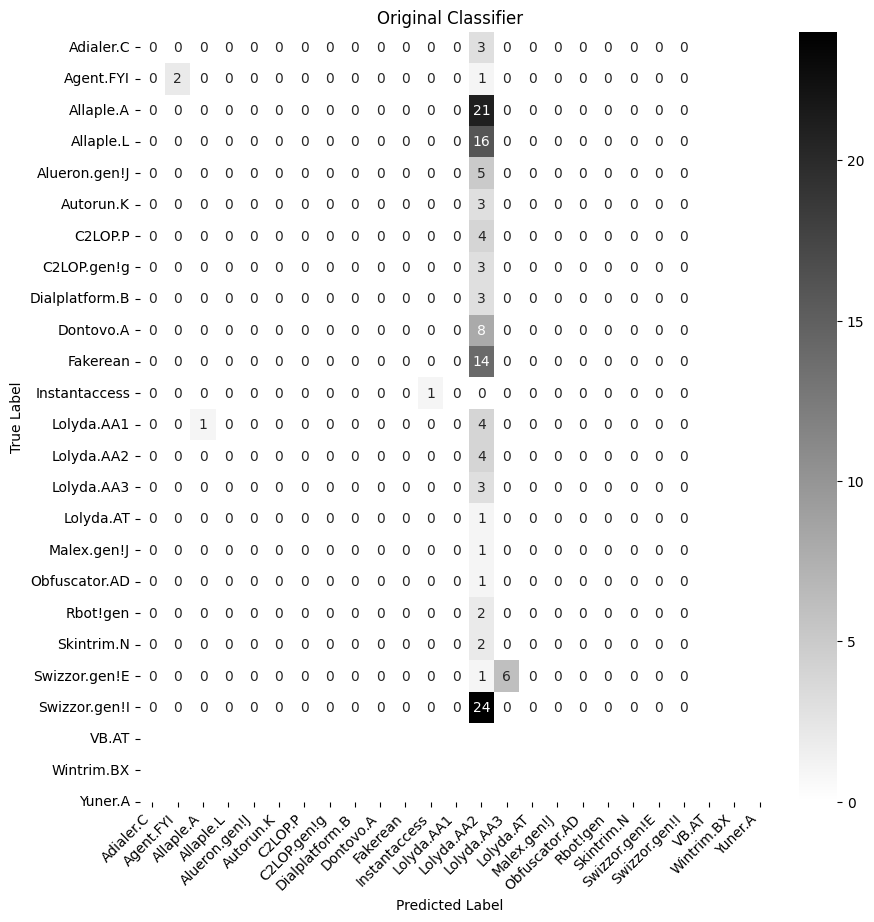

In [56]:
# Ahora la matriz de confusion del modelo robado
cm = confusion_matrix(stolen_true_labels, stolen_predicted_labels)
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='binary', cbar=True, xticklabels=test_data.class_names, yticklabels=test_data.class_names)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Original Classifier')
plt.show()

Vemos que ambos clasifican de manera muy similar lo que indica que el ataque fue realizado con éxito porque se extrajo un modelo existente que funciona casi igual y con una precisión no tan lejana a la del original porque son pocos casos que no clasifica de la misma manera que el original.